#Library

In [1]:
!pip install pyomo


In [2]:
from pyomo.environ import *
from pathlib import Path
import itertools as it
from time import perf_counter as pc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist
import subprocess, sys, shutil
import pyomo.environ as pyo
from pyomo.dae import *

#Synthetic Scenario to proof that Greedy does not guarantee optimality

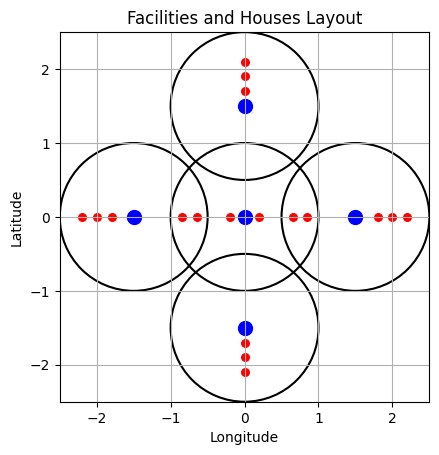

In [3]:
facilities = {
    'center': [0, 0],
    'left': [-1.5, 0],
    'right': [1.5, 0],
    'top': [0, 1.5],
    'bottom': [0, -1.5]
}

houses = {
    'center': [[0.2, 0], [-0.2, 0]],
    'left': [[-2.2, 0], [-2, 0], [-1.8, 0], [-0.85, 0.0],[-0.65, 0.0]],
    'right': [[2.2, 0], [2, 0], [1.8, 0], [0.85, 0.0],[0.65, 0.0]],
    'top': [[0, 1.7], [0, 1.9], [0, 2.1]],
    'bottom': [[0, -1.7], [0, -1.9], [0, -2.1]]
}

facilities_df = pd.DataFrame(facilities).T
facilities_df.columns = ['Longitude', 'Latitude']

houses_df = pd.concat({k: pd.DataFrame(v, columns=['Longitude', 'Latitude']) for k, v in houses.items()}, ignore_index=True)

radius = 1

fig, ax = plt.subplots()
for index, row in facilities_df.iterrows():
    ax.scatter(row['Longitude'], row['Latitude'], color='blue', s=100)
    circle = Circle((row['Longitude'], row['Latitude']), radius, color='black', fill=False, linewidth=1.5)
    ax.add_patch(circle)

ax.scatter(houses_df['Longitude'], houses_df['Latitude'], color='red', s=30)

ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_aspect('equal')
ax.grid(True)

plt.title("Facilities and Houses Layout")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

All weights are equal in this example so equalt to 1

In [4]:
weights = np.ones(len(houses_df))

##Greedy Formulation

In [5]:
def fast_greedy(w, JI, IJ):
    J = list(IJ.keys())

    gain = np.zeros(max(J)+1)
    coverage = np.zeros_like(w, dtype=np.uint16)

    related = { j : np.unique(np.concatenate([JI[i] for i in IJ[j]]))
                for j in J if len(IJ[j])
    }

    def mutation( w, cov, IJ, J, v ):
        return np.array( [w[IJ[j][cov[IJ[j]]==v]].sum() for j in J] )

    sol = []
    gain[J] = mutation( w, coverage, IJ, J, 0 )
    while True:
        s = gain.argmax()
        if gain[s] <= 0:
            break
        coverage[IJ[s]] += 1
        gain[related[s]] = mutation( w, coverage, IJ, related[s], 0 )
        sol.append(s)
    return np.array(sol)

In [6]:
def prepare_greedy_input(facilities_df, houses_df, coverage_radius):
    distances = cdist(houses_df[['Longitude', 'Latitude']], facilities_df[['Longitude', 'Latitude']])

    JI = {}
    IJ = {}

    for i in range(len(houses_df)):
        JI[i] = np.where(distances[i, :] <= coverage_radius)[0]

    for j in range(len(facilities_df)):
        IJ[j] = np.where(distances[:, j] <= coverage_radius)[0]

    return JI, IJ

JI, IJ = prepare_greedy_input(facilities_df, houses_df, 1)

greedy_sequence = fast_greedy(weights, JI, IJ)
print("Selected facilities indices:", greedy_sequence)

Selected facilities indices: [0 1 2 3 4]


Facility name with coordinates

In [7]:
for idx in greedy_sequence:
    facility_name = facilities_df.index[idx]
    facility_info = facilities_df.iloc[idx]
    print(f"Selected Facility: {facility_name}")
    print(f"  Coordinates: Longitude = {facility_info['Longitude']}, Latitude = {facility_info['Latitude']}")

Selected Facility: center
  Coordinates: Longitude = 0.0, Latitude = 0.0
Selected Facility: left
  Coordinates: Longitude = -1.5, Latitude = 0.0
Selected Facility: right
  Coordinates: Longitude = 1.5, Latitude = 0.0
Selected Facility: top
  Coordinates: Longitude = 0.0, Latitude = 1.5
Selected Facility: bottom
  Coordinates: Longitude = 0.0, Latitude = -1.5


#Solve the exact method with pyomo


## Ensure preconditions

In [8]:
def GetListOfInstalledPackages():
    res = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
    return { r.decode().split('==')[0] for r in res.split() }

In [9]:
def EnsurePreConditionsAtColab():
    at_colab = "google.colab" in sys.modules
    if at_colab:
        installed = GetListOfInstalledPackages()
        if not 'pyomo' in installed:
            %pip install -q pyomo
        if not 'highspy' in installed:
            %pip install -q highspy
        if not shutil.which('/usr/bin/cbc'):
            !apt-get install -y -qq coinor-cbc
            assert(shutil.which('/usr/bin/cbc'))
    return at_colab

In [10]:
at_colab = EnsurePreConditionsAtColab()

In [11]:
def ListAvailableSolvers():
    shell_command = "pyomo help --solvers"
    output = subprocess.check_output(shell_command, shell=True).decode()
    return [
        line.strip()[1:]
        for line in output.split()
        if line.strip().startswith("+") and not line.strip().endswith(")")
    ]

In [12]:
available_solvers = ListAvailableSolvers()
print(available_solvers)

['appsi_highs', 'cbc', 'gdpopt', 'gdpopt.enumerate', 'gdpopt.gloa', 'gdpopt.lbb', 'gdpopt.loa', 'gdpopt.ric', 'mindtpy', 'mindtpy.ecp', 'mindtpy.fp', 'mindtpy.goa', 'mindtpy.oa', 'mpec_minlp', 'mpec_nlp', 'multistart', 'scipy.fsolve', 'scipy.newton', 'scipy.root', 'scipy.secant-newton', 'trustregion']


Model Formulaton

In [13]:
distances = cdist(houses_df[['Longitude', 'Latitude']], facilities_df[['Longitude', 'Latitude']])
coverage_radius = 1
houses_dic = {}
facilities_dic = {facility: [] for facility in facilities_df.index}
facility_indices = {name: idx for idx, name in enumerate(facilities_df.index)}

for i in range(len(houses_df)):
    covered_facilities = []
    for j, facility_name in enumerate(facilities_df.index):
        if distances[i, j] <= coverage_radius:
            facility_idx = facility_indices[facility_name]
            covered_facilities.append(facility_idx)
            facilities_dic[facility_name].append(i)

    houses_dic[i] = np.array(covered_facilities, dtype=int)

for facility in facilities_dic:
    facilities_dic[facility] = np.array(facilities_dic[facility], dtype=int)

print("House to Facility (with integer indices for facilities):", houses_dic)
print("Facility to House (with numpy arrays):", facilities_dic)

House to Facility (with integer indices for facilities): {0: array([0]), 1: array([0]), 2: array([1]), 3: array([1]), 4: array([1]), 5: array([0, 1]), 6: array([0, 1]), 7: array([2]), 8: array([2]), 9: array([2]), 10: array([0, 2]), 11: array([0, 2]), 12: array([3]), 13: array([3]), 14: array([3]), 15: array([4]), 16: array([4]), 17: array([4])}
Facility to House (with numpy arrays): {'center': array([ 0,  1,  5,  6, 10, 11]), 'left': array([2, 3, 4, 5, 6]), 'right': array([ 7,  8,  9, 10, 11]), 'top': array([12, 13, 14]), 'bottom': array([15, 16, 17])}


In [14]:
from pyomo.environ import *

def model_max_covering(w, I, J, JI, T):
    m = ConcreteModel()

    m.I = Set(initialize=I)
    m.J = Set(initialize=J)
    m.T = Set(initialize=T)

    m.x = Var(m.J, m.T, within=Binary)
    m.y = Var(m.I, m.T, within=Binary)

    def obj_rule(m):
        return sum(w[i] * m.y[i, t] for t in m.T for i in m.I)
    m.obj = Objective(rule=obj_rule, sense=maximize)

    def coverage_constraint_rule(m, i, t):
        return m.y[i, t] <= sum(sum(m.x[j, tau] for j in JI[i]) for tau in range(1, t+1))
    m.coverage_constraint = Constraint(m.I, m.T, rule=coverage_constraint_rule)

    def facility_deployment_constraint_rule(m, t):
        return sum(m.x[j, t] for j in m.J) == t
    m.facility_deployment_constraint = Constraint(m.T, rule=facility_deployment_constraint_rule)

    def facility_continuity_constraint_rule(m, j, t):
        if t == 1:
            return Constraint.Skip
        return m.x[j, t-1] <= m.x[j, t]
    m.facility_continuity_constraint = Constraint(m.J, m.T, rule=facility_continuity_constraint_rule)

    return m

In [15]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

weights = {i: 1 for i in range(len(houses_df))}

time_periods = list(range(1, 6))
facilities_indices = list(range(len(facilities_df)))
demand_indices = np.arange(len(houses_df))

model = model_max_covering(weights, range(len(houses_df)), facilities_indices, houses_dic, time_periods)

Optimal Objective Value: 62.0
Facilities opened in period 1:
Facility 1 is opened
Facilities opened in period 2:
Facility 1 is opened
Facility 2 is opened
Facilities opened in period 3:
Facility 1 is opened
Facility 2 is opened
Facility 3 is opened
Facilities opened in period 4:
Facility 1 is opened
Facility 2 is opened
Facility 3 is opened
Facility 4 is opened
Facilities opened in period 5:
Facility 0 is opened
Facility 1 is opened
Facility 2 is opened
Facility 3 is opened
Facility 4 is opened


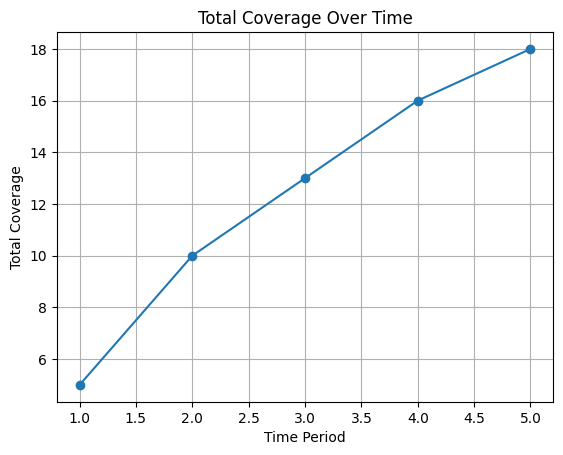

In [19]:
solver = SolverFactory('cbc')
results = solver.solve(model)

if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print("Optimal Objective Value:", model.obj())

    for t in time_periods:
        print(f"Facilities opened in period {t}:")
        for j in facilities_indices:
            if model.x[j, t].value == 1:
                print(f"Facility {j} is opened")

    total_coverage = [sum(weights[i] * model.y[i, t].value for i in range(len(houses_df))) for t in time_periods]
    plt.plot(time_periods, total_coverage, marker='o', linestyle='-')
    plt.xlabel('Time Period')
    plt.ylabel('Total Coverage')
    plt.title('Total Coverage Over Time')
    plt.grid(True)
    plt.show()
else:
    print("Solver did not converge to optimality")

facility_names = {
    0: 'center',
    1: 'left',
    2: 'right',
    3: 'top',
    4: 'bottom'
}

#Plot the difference between the coverage of the Greedy Algorithm and the Optimal solution

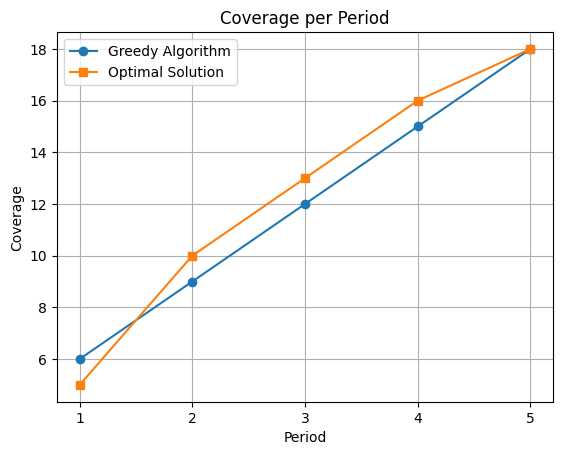

In [17]:
greedy_coverage = [6, 9, 12, 15, 18]
optimal_coverage = [5, 10, 13, 16, 18]

periods = range(1, 6)

plt.plot(periods, greedy_coverage, marker='o', label='Greedy Algorithm')
plt.plot(periods, optimal_coverage, marker='s', label='Optimal Solution')

plt.xlabel('Period')
plt.ylabel('Coverage')
plt.title('Coverage per Period')
plt.legend()
plt.grid(True)
plt.xticks(periods)

plt.show()

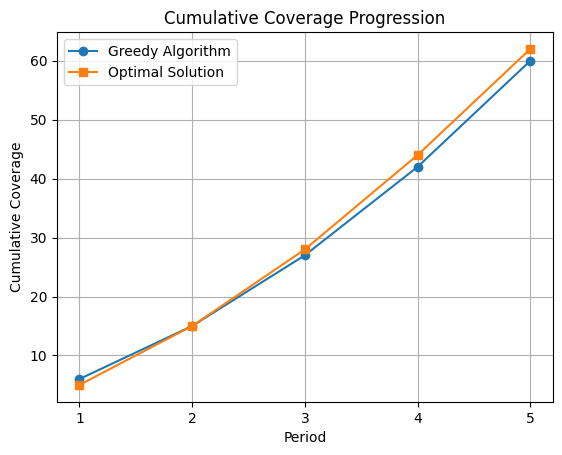

In [18]:
greedy_coverage = [6, 9, 12, 15, 18]
optimal_coverage = [5, 10, 13, 16, 18]

greedy_cumulative_coverage = [sum(greedy_coverage[:i+1]) for i in range(len(greedy_coverage))]
optimal_cumulative_coverage = [sum(optimal_coverage[:i+1]) for i in range(len(optimal_coverage))]

periods = range(1, 6)

plt.plot(periods, greedy_cumulative_coverage, marker='o', label='Greedy Algorithm')
plt.plot(periods, optimal_cumulative_coverage, marker='s', label='Optimal Solution')

plt.xlabel('Period')
plt.ylabel('Cumulative Coverage')
plt.title('Cumulative Coverage Progression')
plt.legend()
plt.grid(True)
plt.xticks(periods)

plt.show()